In [1]:
from google.colab import drive
import os
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pwd
%cd /content/drive/MyDrive/LSTM project/LSTM_Project/sector_analysis(food drug)

/content
/content/drive/MyDrive/LSTM project/LSTM_Project/sector_analysis(food drug)


In [3]:
# sector-> Food & Drug store(2017/01/01~2020/12/31) 
import pandas as pd
df1=pd.read_csv("SVNDY.csv") 
df2=pd.read_csv("WBA.csv")  
df3=pd.read_csv("MTRAF.csv")
df4=pd.read_csv("COOP.csv") 
df5=pd.read_csv("JSAIY.csv")  
df6=pd.read_csv("ADRNY.csv")  
df7=pd.read_csv("TSCDY.csv")  
df8=pd.read_csv("KR.csv")    
df9=pd.read_csv("AGHC.csv")  
df10=pd.read_csv("CRRFY.csv") 
df11=pd.read_csv("WNGRF.csv") 

c=[df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11]
nl=["Seven & I Holdings (Japan)", "Walgreens Boots Alliance (USA)", "Metro (Canada)", 'Coop Group (Switzerland)', 'J.Sainsbury(Britain)',
    "Royal Ahold Delhaize(Netherlands)", "Tesco(Britain)", "Kroger(USA)", "AEON(Japan)", "Carrefour(France)", "George Weston(Canada)"]

print(df1.shape, df2.shape, df3.shape, df4.shape, df5.shape, df6.shape, df7.shape, df8.shape, df9.shape, df10.shape, df11.shape)

(1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7)


# Make models

In [4]:
from keras.layers import *
def make_models(c, nl, v, V=False, output_c=['High'], output_i=[2], train_size=754, time_step=60, epochs=30, units=50): 
  import warnings
  warnings.simplefilter('ignore')
  import math
  import seaborn as sns
  import matplotlib.pyplot as plt
  import keras
  import pandas as pd
  import numpy as np
  from keras.models import Sequential
  from keras.layers import Dense
  from keras.layers import LSTM
  from keras.layers import Dropout
  from sklearn.preprocessing import MinMaxScaler
  from sklearn.preprocessing import StandardScaler
  from sklearn.metrics import mean_squared_error
  from sklearn.metrics import mean_absolute_error
  from sklearn.model_selection import train_test_split
  from keras.callbacks import EarlyStopping
  """
  items={"Date":0, "Open":1, "High":2, "Low":3, "Close":4, "Adj Close":5, "Volume":6}
  v=[1, 2, 3, 4, 6]  
  output_c=['High']
  output_i=[2] 　"""
  
  #1. split train and test data
  train_data=[]
  test_data=[]
  for i in range(len(c)):
    train_data.append(c[i].iloc[: train_size, v].values)
    test_data.append(c[i].iloc[train_size:, v].values)
  print(f"train_data={np.array(train_data).shape}, test_data={np.array(test_data).shape}")

  #2. train_data->normalise depending on number of inputs (only the volume is processed separately as the scale is different)
  #3. make X_train, y_train flexibly
  X_train=[]
  y_trains=[]
  
  if len(output_i) != 1:
    print(f"output>=2, inputs={v}, outputs={output_c}")
    training_set_others=np.hstack((data[:,:-1] for data in train_data))
    training_set_volume=np.hstack((data[:,-1:].reshape(-1, 1) for data in train_data))

    ss_others=[]
    for i in range(training_set_others.shape[1]):
      ss1=StandardScaler()
      ss_others.append(ss1.fit_transform(training_set_others[:,i].reshape(-1, 1)))
    ss_others=np.hstack(ss_others)

    ss2=StandardScaler()
    ss_v=ss2.fit_transform(training_set_volume)
    concat=np.hstack((ss_others, ss_v))
    print(f"concat={concat.shape}")

    #ind=output用のvariablesのindexを抜き取る=>個別に学習モデルを作成するため
    if 6 in output_i: 
      print("Volume含む")
      ind = []
      for i in range(len(output_i)):
        if output_i[i] != 6:
          ind+=[j for j in range(v.index(output_i[i]), len(c)*(len(v)-1), len(v)-1)] 
        else:
          ind+=[k for k in range(len(c)*(len(v)-1), len(c)*len(v))]
                              
      print(f"len(ind)={len(ind)}, ind={ind}")
      for l in range(time_step, train_size):
        X_train.append(concat[l-time_step: l, :])
        for m in range(len(ind)):
          y_trains.append(concat[l, ind[m]])
      print(len(X_train), len(y_trains))

    else:
      print("Volume含まない")
      ind=[]
      for i in range(len(output_i)):
        ind+=[j for j in range(v.index(output_i[i]), len(c)*(len(v)), len(v))] 
      print(f"num_of_companies={len(c)}, ind={ind}")
      
      for l in range(time_step, train_size):
        X_train.append(concat[l-time_step: l, :])
        for m in range(len(ind)):
          y_trains.append(concat[l, ind[m]])
      print(len(X_train), len(y_trains))

  else: #outputが１つの時
    if V:
      print("Here check")
      print(f"output=1, inputs={v}, outputs={output_c}")

      training_set_volume=np.hstack((data[:,-1].reshape(-1, 1) for data in train_data))
      ss2=StandardScaler()
      ss_v=ss2.fit_transform(training_set_volume)

      print(f"concat={ss_v.shape}")

      ind = [id for id in range(len(c))]
      print(f"num_of_companies={len(c)}, ind={ind}")

      for j in range(time_step, train_size):
        X_train.append(ss_v[j-time_step: j, :])
        for k in range(len(ind)):
          y_trains.append(ss_v[j, ind[k]])

    else: # volume含まれていない時
      print("volule以外かつinputとoutputは1つ")
      training_set_all=np.hstack(np.array(train_data))
      ss2=StandardScaler()
      ss_others=ss2.fit_transform(training_set_all)
      concat=ss_others

      ind = [id for id in range(len(c))]
      print(f"num_of_companies={len(c)}, ind={ind}")

      for j in range(time_step, train_size):
        X_train.append(concat[j-time_step: j, :])
        for k in range(len(ind)):
          y_trains.append(concat[j, ind[k]])

  X_train=np.array(X_train)
  y_trains=np.array(y_trains)
  print(f"X_train={X_train.shape}, y_trains={y_trains.shape}")
  # print("finish making X_train and y_trains")
  #3.train models(numbers of companies)

  y_trains2=[]
  
  if len(output_i) != 1:
    for x in range(len(c)*len(output_i)):
      x_tr=np.array([y_trains[i] for i in range(x, len(y_trains), len(c)*len(output_i))])
      y_trains2.append(x_tr)

  else: # len(output_i)==1
    for y in range(len(c)):
      y_tr=np.array([y_trains[i] for i in range(y, len(y_trains), len(c))])
      y_trains2.append(y_tr)

  y_trains2=np.array(y_trains2)
  print(f"y_trains2={y_trains2.shape}")

  print("Check")
  model_lists = []
  for l in range(len(y_trains2)):
    print(f"{l+1}/{len(y_trains2)}")
    model = Sequential()
    #Adding the first LSTM layer and some Dropout regularisation
    # ここのinput_shapeで入力次元を設定する
    model.add(LSTM(units = units, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2] )))
    model.add(Dropout(0.2))
    # Adding a second LSTM layer and some Dropout regularisation
    model.add(LSTM(units = units, return_sequences = True))
    model.add(Dropout(0.2))
    # Adding a third LSTM layer and some Dropout regularisation
    model.add(LSTM(units = units, return_sequences = True))
    model.add(Dropout(0.2))
    # Adding a fourth LSTM layer and some Dropout regularisation
    model.add(LSTM(units = units))
    model.add(Dropout(0.2))
    # Adding the output layer
    model.add(Dense(units = 1))

    # Compiling the RNN
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    # Fitting the RNN to the Training set
    model.fit(X_train, y_trains2[l], epochs=epochs, batch_size=32)
    model_lists.append(model)
    print("")
  print("finish making models")
  return model_lists, y_trains2

# Make preds

In [5]:
# Make predictions
def make_preds(c, nl, v, model_lists, y_trains2, V=False, output_c=['High'], output_i=[2], train_size=754, time_step=60):
  import warnings
  warnings.simplefilter('ignore')
  import math
  import seaborn as sns
  import matplotlib.pyplot as plt
  import keras
  import pandas as pd
  import numpy as np
  from keras.models import Sequential
  from keras.layers import Dense
  from keras.layers import LSTM
  from keras.layers import Dropout
  from sklearn.preprocessing import MinMaxScaler
  from sklearn.preprocessing import StandardScaler
  from sklearn.metrics import mean_squared_error
  from sklearn.metrics import mean_absolute_error
  from sklearn.model_selection import train_test_split
  from keras.callbacks import EarlyStopping

  #4. Prepare test data and normalise and make predictions
  train_data=[]
  test_data=[]
  for i in range(len(c)):
    train_data.append(c[i].iloc[: train_size, v].values)
    test_data.append(c[i].iloc[train_size:, v].values)
  print(f"train_data={np.array(train_data).shape}, test_data={np.array(test_data).shape}")

  inputs = []
  
  for m in range(len(c)): # ここではvで指定したvariablesだけのarrayに加工している
    inputs.append(c[m].iloc[:, v][len(c[m])-len(test_data[m])-time_step:].values)
  
  inputs = np.array(inputs)
  print(f"inputs = {np.array(inputs).shape}")

  #train_data=(11, 754, 2), test_data=(11, 252, 2)
  # inputs = (11, 282, 2)
  # Volumeを含むケース
  # inputs = (11, 282, 2)
  variables=[]
  ss=[]
  for i in range(len(c)):
    for j in range(len(v)): #11*5=55
      m=inputs[i, :, j].reshape(-1, 1) 
      s=StandardScaler()
      t=s.fit_transform(m)

      variables.append(t)
      ss.append(s)
  
  inputs2=np.hstack(variables)
  print(f"inputs2={inputs2.shape}")
  s1=StandardScaler()
  inputs2=s1.fit_transform(inputs2)
  
  X_test = []
  # use all components as imputs for testing
  for n in range(time_step, np.array(test_data).shape[1]+time_step):
    X_test.append(inputs2[n-time_step:n, :])

  X_test = np.array(X_test)
  print(f"X_test={X_test.shape}")
  #X_test=(252, 30, 22)

  preds = [] #(11, 252) (252, 1)
  for o in range(len(y_trains2)):
    preds.append(np.array(model_lists[o].predict(X_test)))
  
  if len(output_i)==1:
    ind=[i for i in range(v.index(output_i[0]), len(c)*len(v), len(v))]
  else:
    ind=[]
    for i in range(len(output_i)):
      ind+=[j for j in range(v.index(output_i[i]), len(c)*len(v), len(v))]
    print(ind)

  for p in range(len(y_trains2)): #(252, 11)
    preds[p] = ss[ind[p]].inverse_transform(preds[p]) #修正必要
  preds = np.array(preds)

  print("finish making predictions")
  #5. Plot actual vs preds
  # df ={"Date":0, "Open":1, "High":2, "Low":3, "Close":4, "Adj Close":5, "Volume":6] 
  actual_lists=[]
  for dd in range(len(output_i)):
    # for cc in range(len(c)):
    actual_lists+=[sc.iloc[train_size:,output_i[dd]] for sc in c]
  
  if len(output_i) > 1:
    R2=nl*len(output_i) # lists of companies
  else: R2=nl
  
  print(f"actual lists={np.array(actual_lists).shape}, preds_list={np.array(preds).shape}")

  R=0
  r=[r for r in range(len(c)-1, len(R2), len(c))]
  print(r)
  for p in range(len(R2)):
    plt.figure(figsize=(10, 6)) 
    plt.plot(c[0].loc[train_size:,'Date'], actual_lists[p], color='red', label='Real')
    plt.plot(c[0].loc[train_size:,'Date'], preds[p], color='blue', label='Predict')
    from sklearn.metrics import r2_score

    plt.xticks(np.arange(0, 300, 30))
    # plt.title(f"{}")
    plt.xlabel('Time series')
    plt.ylabel('Stock Price (or Volume)')
    
    # use correlation
    print(f"R2{R2[p]}={r2_score(actual_lists[p], preds[p].flatten())}")
 
    R +=r2_score(actual_lists[p], preds[p].flatten())
    plt.legend()
    plt.show()

    if p in r:
      print(f"R2-{len(c)}companies_average={R/len(c)}")
      R=0
      print("")

  #6. Make confusion matrix

  columns = nl # labeling 
  # Actual 
  # print("Actual")
  # act=[a for a in actual_lists]
  # Actual=pd.concat(act, axis=1)
  # Actual.columns = columns
  # plt.figure(figsize=(12, 10))
  # cmap=sns.diverging_palette(220, 20, as_cmap=True)
  # sns.heatmap(Actual.corr(method='spearman'), cmap=cmap, annot=True) 

  # Predictions
  for p in range(len(output_i)):
    print(f"Preds_Heatmap={output_c[p]} correlation")
    prd=[preds[p] for p in range(len(c)*p, len(c)+p*len(c))]
    # print(len(prd))
    Preds= pd.DataFrame(np.concatenate(prd, axis=1))
    Preds.columns = columns
    # print(Preds.columns)
    plt.figure(figsize=(8, 6))
    cmap=sns.diverging_palette(220, 20, as_cmap=True)
    sns.heatmap(Preds.corr(method='spearman'), cmap=cmap, annot=True) 

  # return preds[p].flatten()

  """Metro can be a special case, but the ohter companies in the same sector would have a sort of similarity. """

# "Experiments"
###Sector: Food & Drug
### Criteria: Profits/Employees 

# [What I got from various experiments]
### It can be difficult to decrease Loss function in the case of 'Only Volume'
### As time_step increases, R2 decreases.
### As number of epoch increases, R2 generally increases (Except for 'Volume')
### Even if number of neurons increase, not necesssarily increase R2 (too much may contribute to overfit)


# 6月9日以降　
####(1) まずはランダム２社選択して、HighとValueそれぞれのR2を算出していく
####(2) R2>=0.9(最悪R2>=0.8)ならばOKで３社,４社・・・・と増やしていく
####(3) 何社目に増やしたところでスコアが急激に落ちるかデータを取る
### 複数会社のLSTM: https://memo.soarcloud.com/%E6%B7%B1%E5%B1%A4%E5%AD%A6%E7%BF%92%E3%81%8B%E3%82%89%E4%B8%8A%E3%81%8C%E3%82%8B%E6%A0%AA%E3%81%BF%E3%81%A4%E3%81%8B%E3%82%8B/

Text(0, 0.5, 'R2(%)')

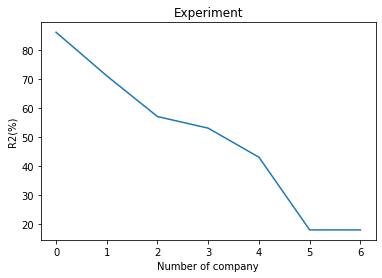

In [17]:
# 集計データ {time_step=60days, number_of_epoch=20time, number_of_neuron=120, normalised}
R2_High_20_120={"2":0.86,"3":0.71,"4":0.57,"5":0.53,"6":0.43,"7":0.18,"8":0.18}
R2_High_50_150={"2":0.90,"3":0.71,"4":0.57,"5":0.53,"6":0.43,"7":0.18,"8":0.18}
R2_Score_Volume={"2":0.01,"3":0.009,"4":-0.13} # no meanigful result

# Note: Tesco's stock price movement can be tricy, this influence the overall R2. 

import matplotlib.pyplot as plt
x = [i for i in range(7)]
v=100
y1 = [0.86*v, 0.71*v, 0.57*v, 0.53*v, 0.43*v, 0.18*v, 0.18*v]
y2 = [0.86*v, 0.71*v, 0.57*v, 0.53*v, 0.43*v, 0.18*v, 0.18*v]
plt.plot(x, y1)
plt.title('Experiment(epoch=20, nodes=120)')
plt.xlabel('Number of company')
plt.ylabel('R2(%)')
plt.plot(x, y2)
plt.title('Experiment(epoch=20, nodes=120)')

# N=2

In [ ]:
data=[df1, df2] 
company_list=["Seven & I Holdings (Japan)", "Walgreens Boots Alliance (USA)"]
items={"Date":0, "Open":1, "High":2, "Low":3, "Close":4, "Adj Close":5, "Volume":6}

# Basically, we can remove "Date" and "Adj Close"
input=[2] #item' index chosen as imputs
output_c=['High'] # item values of output
output_i=[2] # item number of output

train_size=754
time_step=60
epochs=20
units=120 # number of nodes

# V means whether "Volume" may be included or not
if 6 not in input:
  V=False
else: V=True

In [ ]:
# default: make_models(c, nl, v, V=False, output_c=['High'], output_i=[2], train_size=754, time_step=60, epochs=30, units=50)
o3, o4 = make_models(data, company_list, input, V=V, output_c=output_c, output_i=output_i, 
                     train_size=train_size, time_step=time_step, epochs=epochs, units=units)

train_data=(2, 754, 1), test_data=(2, 252, 1)
volule以外かつinputとoutputは1つ
num_of_companies=2, ind=[0, 1]
X_train=(694, 60, 2), y_trains=(1388,)
y_trains2=(2, 694)
Check
1/2
Epoch 1/20
22/22 [==============================] - 13s 257ms/step - loss: 0.3622
Epoch 2/20
22/22 [==============================] - 6s 258ms/step - loss: 0.1523
Epoch 3/20
22/22 [==============================] - 6s 257ms/step - loss: 0.1373
Epoch 4/20
22/22 [==============================] - 6s 257ms/step - loss: 0.1066
Epoch 5/20
22/22 [==============================] - 6s 254ms/step - loss: 0.0973
Epoch 6/20
22/22 [==============================] - 6s 255ms/step - loss: 0.0934
Epoch 7/20
22/22 [==============================] - 6s 254ms/step - loss: 0.1007
Epoch 8/20
22/22 [==============================] - 6s 258ms/step - loss: 0.0894
Epoch 9/20
22/22 [==============================] - 6s 261ms/step - loss: 0.0790
Epoch 10/20
22/22 [==============================] - 6s 257ms/step - loss: 0.0723
Epoch 11/20
22/22

train_data=(2, 754, 1), test_data=(2, 252, 1)
inputs = (2, 312, 1)
inputs2=(312, 2)
X_test=(252, 60, 2)
finish making predictions
actual lists=(2, 252), preds_list=(2, 252, 1)
[1]
R2Seven & I Holdings (Japan)=0.8327072097526654


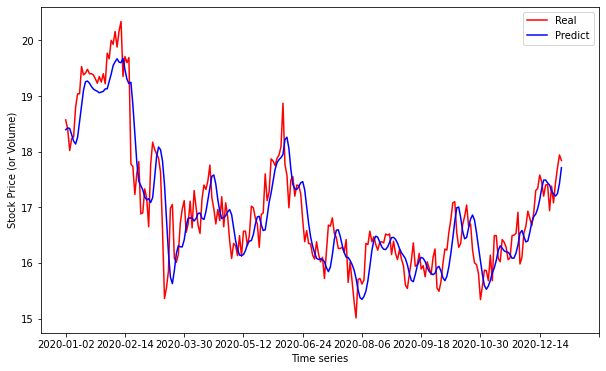

R2Walgreens Boots Alliance (USA)=0.8925175700650483


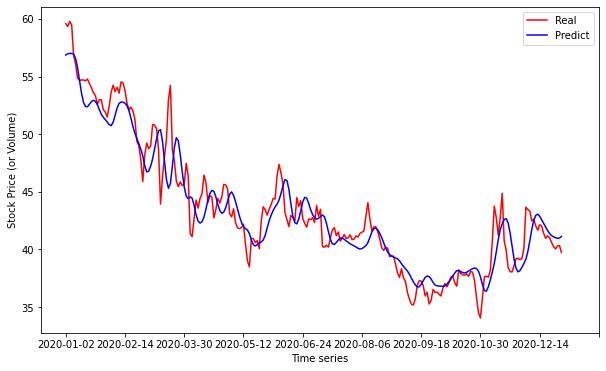

R2-2companies_average=0.8626123899088569

Preds_Heatmap=High correlation


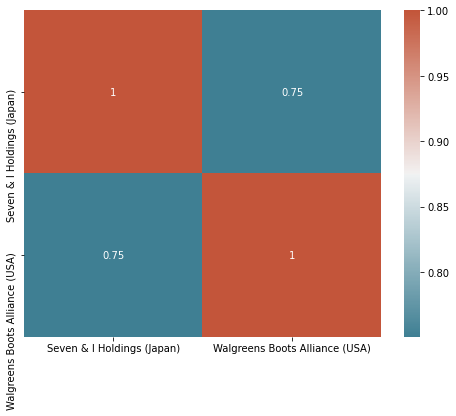

In [ ]:
# test(prediction)
t2 = make_preds(data, company_list, input, o3, o4, V=V, output_c=output_c, output_i=output_i, train_size=train_size, time_step=time_step)

#N=3

In [ ]:
data=[df1, df2, df3] 
company_list=["Seven & I Holdings (Japan)", "Walgreens Boots Alliance (USA)", "Metro (Canada)"]
items={"Date":0, "Open":1, "High":2, "Low":3, "Close":4, "Adj Close":5, "Volume":6}

# Basically, we can remove "Date" and "Adj Close"
input=[2] #item' index chosen as imputs
output_c=['High'] # item values of output
output_i=[2] # item number of output

train_size=754
time_step=60
epochs=20
units=120 # number of nodes

# V means whether "Volume" may be included or not
if 6 not in input:
  V=False
else: V=True

In [ ]:
# train 
o3, o4 = make_models(data, company_list, input, V=V, output_c=output_c, output_i=output_i, 
                     train_size=train_size, time_step=time_step, epochs=epochs, units=units)

train_data=(3, 754, 1), test_data=(3, 252, 1)
volule以外かつinputとoutputは1つ
num_of_companies=3, ind=[0, 1, 2]
X_train=(694, 60, 3), y_trains=(2082,)
y_trains2=(3, 694)
Check
1/3
Epoch 1/20
22/22 [==============================] - 13s 256ms/step - loss: 0.5007
Epoch 2/20
22/22 [==============================] - 6s 252ms/step - loss: 0.1319
Epoch 3/20
22/22 [==============================] - 6s 253ms/step - loss: 0.0985
Epoch 4/20
22/22 [==============================] - 6s 253ms/step - loss: 0.1005
Epoch 5/20
22/22 [==============================] - 6s 255ms/step - loss: 0.0973
Epoch 6/20
22/22 [==============================] - 6s 257ms/step - loss: 0.0767
Epoch 7/20
22/22 [==============================] - 6s 256ms/step - loss: 0.0808
Epoch 8/20
22/22 [==============================] - 6s 255ms/step - loss: 0.0823
Epoch 9/20
22/22 [==============================] - 6s 254ms/step - loss: 0.0838
Epoch 10/20
22/22 [==============================] - 6s 252ms/step - loss: 0.0833
Epoch 11/20
22

train_data=(3, 754, 1), test_data=(3, 252, 1)
inputs = (3, 312, 1)
inputs2=(312, 3)
X_test=(252, 60, 3)
finish making predictions
actual lists=(3, 252), preds_list=(3, 252, 1)
[2]
R2Seven & I Holdings (Japan)=0.4754574564684708


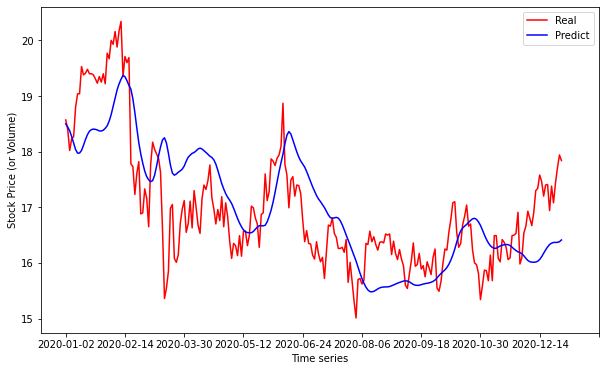

R2Walgreens Boots Alliance (USA)=0.8251423698825353


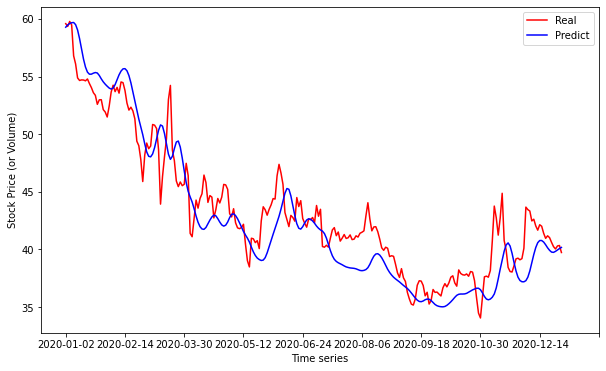

R2Metro (Canada)=0.8401108705242709


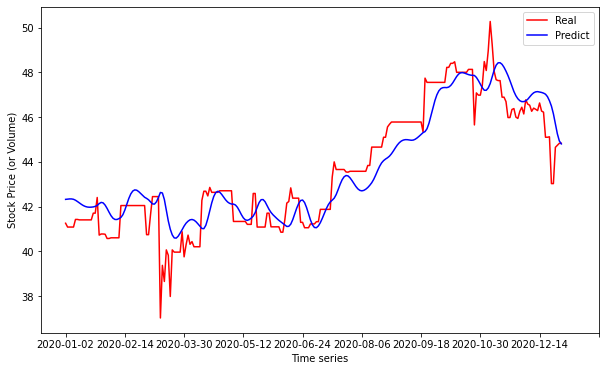

R2-3companies_average=0.713570232291759

Preds_Heatmap=High correlation


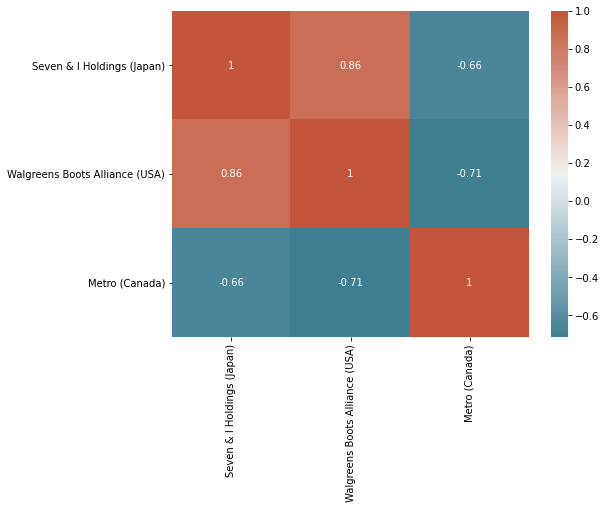

In [ ]:
# test(prediction)
t2 = make_preds(data, company_list, input, o3, o4, V=V, output_c=output_c, output_i=output_i, train_size=train_size, time_step=time_step)

#N=4

In [ ]:
data=[df1, df2, df3, df4] 
company_list=["Seven & I Holdings (Japan)", "Walgreens Boots Alliance (USA)", "Metro (Canada)", 'Coop Group (Switzerland)']
items={"Date":0, "Open":1, "High":2, "Low":3, "Close":4, "Adj Close":5, "Volume":6}

# Basically, we can remove "Date" and "Adj Close"
input=[2] #item' index chosen as imputs
output_c=['High'] # item values of output
output_i=[2] # item number of output

train_size=754
time_step=60
epochs=20
units=120 # number of nodes

# V means whether "Volume" may be included or not
if 6 not in input:
  V=False
else: V=True

In [ ]:
# train 
o3, o4 = make_models(data, company_list, input, V=V, output_c=output_c, output_i=output_i, 
                     train_size=train_size, time_step=time_step, epochs=epochs, units=units)

train_data=(4, 754, 1), test_data=(4, 252, 1)
volule以外かつinputとoutputは1つ
num_of_companies=4, ind=[0, 1, 2, 3]
X_train=(694, 60, 4), y_trains=(2776,)
y_trains2=(4, 694)
Check
1/4
Epoch 1/20
22/22 [==============================] - 29s 263ms/step - loss: 0.4074
Epoch 2/20
22/22 [==============================] - 6s 256ms/step - loss: 0.1262
Epoch 3/20
22/22 [==============================] - 6s 255ms/step - loss: 0.0889
Epoch 4/20
22/22 [==============================] - 6s 253ms/step - loss: 0.0953
Epoch 5/20
22/22 [==============================] - 6s 255ms/step - loss: 0.0794
Epoch 6/20
22/22 [==============================] - 6s 252ms/step - loss: 0.0785
Epoch 7/20
22/22 [==============================] - 6s 253ms/step - loss: 0.0723
Epoch 8/20
22/22 [==============================] - 6s 254ms/step - loss: 0.0647
Epoch 9/20
22/22 [==============================] - 6s 254ms/step - loss: 0.0720
Epoch 10/20
22/22 [==============================] - 6s 253ms/step - loss: 0.0700
Epoch 11/20

train_data=(4, 754, 1), test_data=(4, 252, 1)
inputs = (4, 312, 1)
inputs2=(312, 4)
X_test=(252, 60, 4)
finish making predictions
actual lists=(4, 252), preds_list=(4, 252, 1)
[3]
R2Seven & I Holdings (Japan)=0.44097522858730054


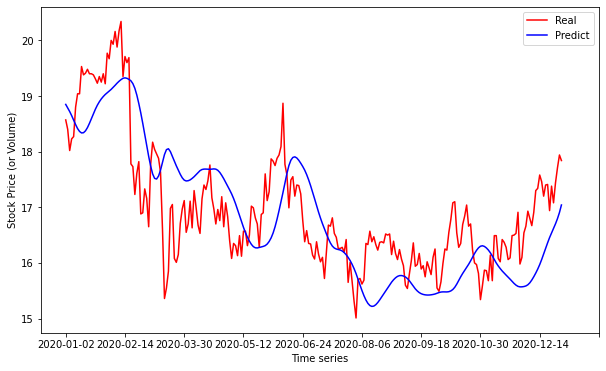

R2Walgreens Boots Alliance (USA)=0.5545035458748306


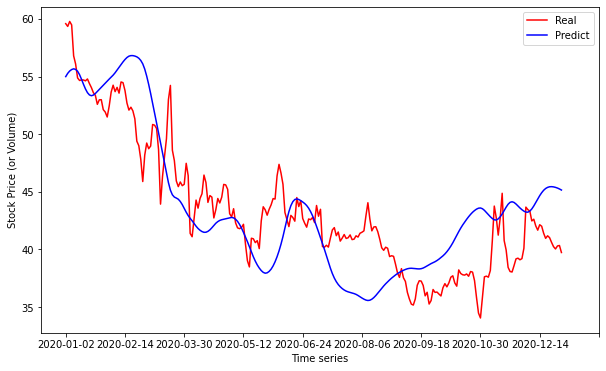

R2Metro (Canada)=0.49433282567273384


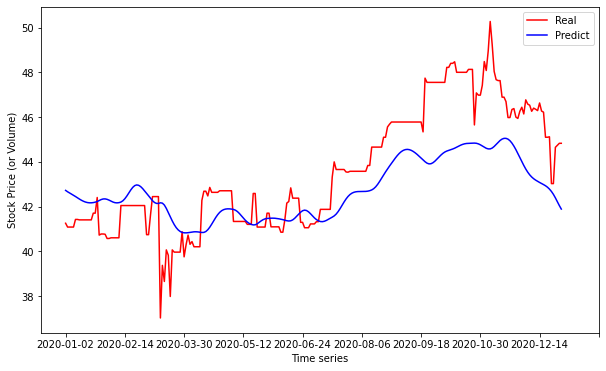

R2Coop Group (Switzerland)=0.8164531720785275


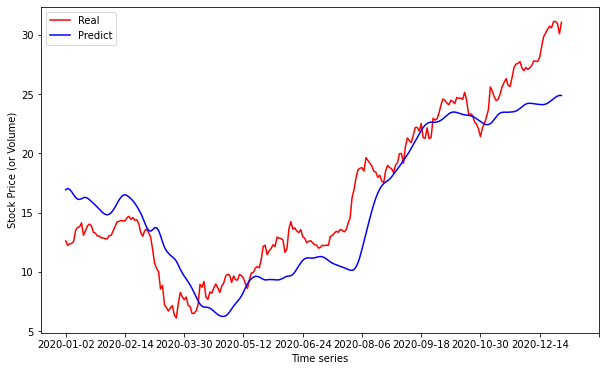

R2-4companies_average=0.5765661930533481

Preds_Heatmap=High correlation


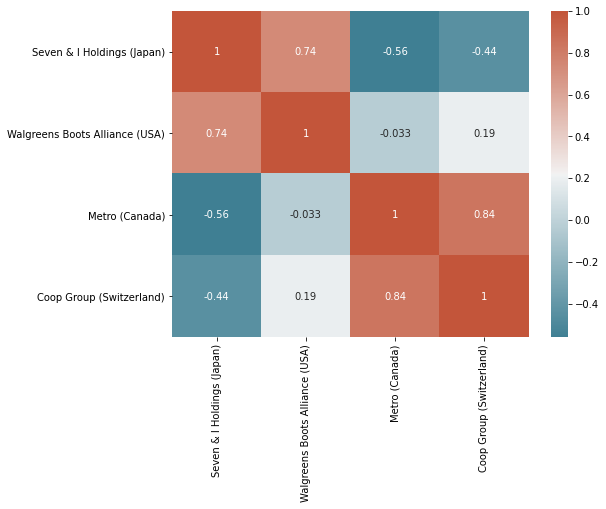

In [ ]:
# test(prediction)
t2 = make_preds(data, company_list, input, o3, o4, V=V, output_c=output_c, output_i=output_i, train_size=train_size, time_step=time_step)

# N=5

In [ ]:
data=[df1, df2, df3, df4, df5] 
company_list=["Seven & I Holdings (Japan)", "Walgreens Boots Alliance (USA)", "Metro (Canada)", 'Coop Group (Switzerland)', 'J.Sainsbury(Britain)']
items={"Date":0, "Open":1, "High":2, "Low":3, "Close":4, "Adj Close":5, "Volume":6}

# Basically, we can remove "Date" and "Adj Close"
input=[2] #item' index chosen as imputs
output_c=['High'] # item values of output
output_i=[2] # item number of output

train_size=754
time_step=60
epochs=20
units=120 # number of nodes

# V means whether "Volume" may be included or not
if 6 not in input:
  V=False
else: V=True

In [ ]:
# train 
o3, o4 = make_models(data, company_list, input, V=V, output_c=output_c, output_i=output_i, 
                     train_size=train_size, time_step=time_step, epochs=epochs, units=units)

train_data=(5, 754, 1), test_data=(5, 252, 1)
volule以外かつinputとoutputは1つ
num_of_companies=5, ind=[0, 1, 2, 3, 4]
X_train=(694, 60, 5), y_trains=(3470,)
y_trains2=(5, 694)
Check
1/5
Epoch 1/20
22/22 [==============================] - 13s 255ms/step - loss: 0.5855
Epoch 2/20
22/22 [==============================] - 6s 251ms/step - loss: 0.1214
Epoch 3/20
22/22 [==============================] - 6s 252ms/step - loss: 0.1059
Epoch 4/20
22/22 [==============================] - 6s 253ms/step - loss: 0.1009
Epoch 5/20
22/22 [==============================] - 6s 254ms/step - loss: 0.0753
Epoch 6/20
22/22 [==============================] - 6s 252ms/step - loss: 0.0700
Epoch 7/20
22/22 [==============================] - 6s 251ms/step - loss: 0.0614
Epoch 8/20
22/22 [==============================] - 6s 254ms/step - loss: 0.0669
Epoch 9/20
22/22 [==============================] - 6s 254ms/step - loss: 0.0597
Epoch 10/20
22/22 [==============================] - 6s 253ms/step - loss: 0.0576
Epoch 11

train_data=(5, 754, 1), test_data=(5, 252, 1)
inputs = (5, 312, 1)
inputs2=(312, 5)
X_test=(252, 60, 5)
finish making predictions
actual lists=(5, 252), preds_list=(5, 252, 1)
[4]
R2Seven & I Holdings (Japan)=0.49755389193268096


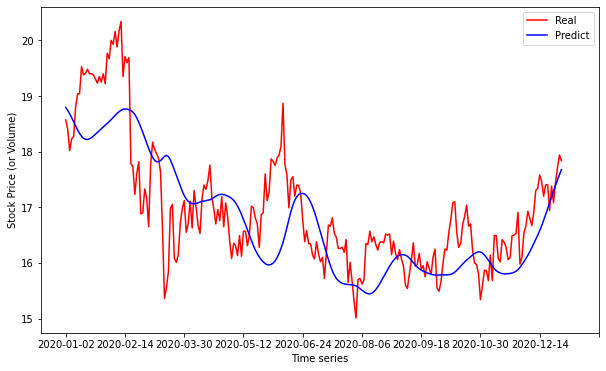

R2Walgreens Boots Alliance (USA)=0.5741771857889959


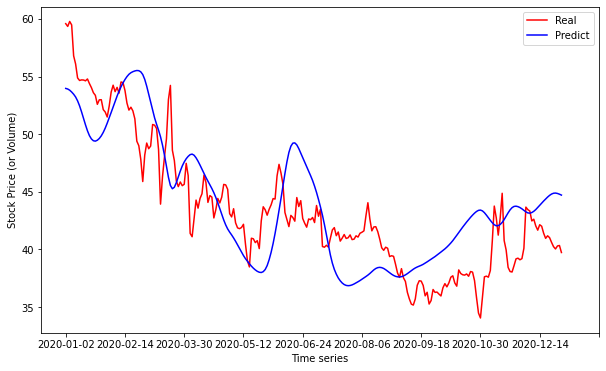

R2Metro (Canada)=0.7147175727754433


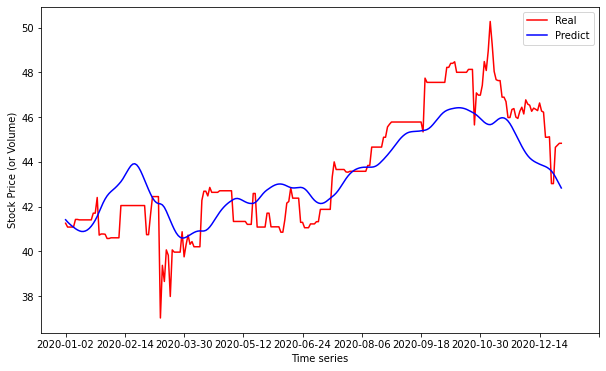

R2Coop Group (Switzerland)=0.26876919090894824


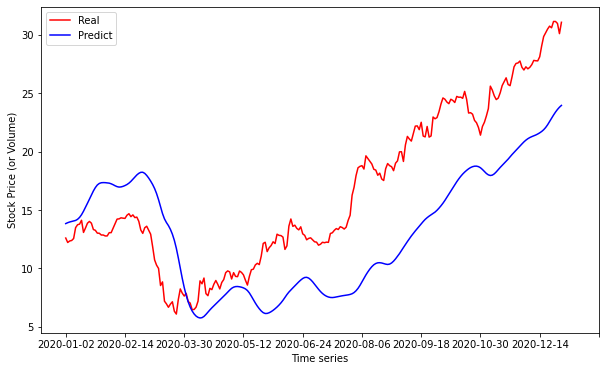

R2J.Sainsbury(Britain)=0.6053956296491897


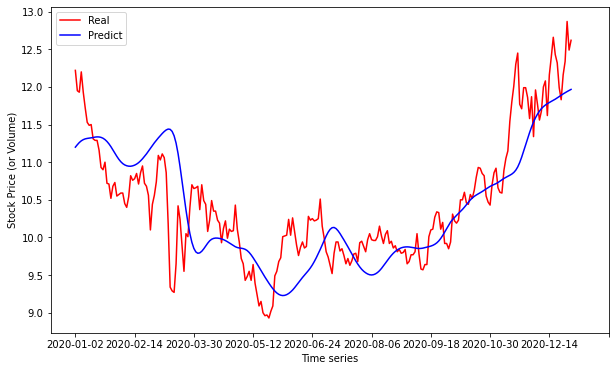

R2-5companies_average=0.5321226942110516

Preds_Heatmap=High correlation


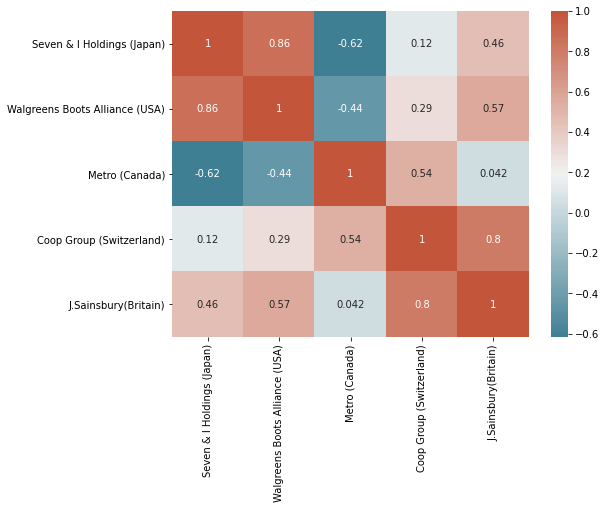

In [ ]:
# test(prediction)
t2 = make_preds(data, company_list, input, o3, o4, V=V, output_c=output_c, output_i=output_i, train_size=train_size, time_step=time_step)

#N=6

In [ ]:
data=[df1, df2, df3, df4, df5, df6] 
company_list=["Seven & I Holdings (Japan)", "Walgreens Boots Alliance (USA)", "Metro (Canada)", "Coop Group (Switzerland)'", "J.Sainsbury(Britain)", "Royal Ahold Delhaize(Netherlands)"]
items={"Date":0, "Open":1, "High":2, "Low":3, "Close":4, "Adj Close":5, "Volume":6}

# Basically, we can remove "Date" and "Adj Close"
input=[2] #item' index chosen as imputs
output_c=['High'] # item values of output
output_i=[2] # item number of output

train_size=754
time_step=60
epochs=20
units=120 # number of nodes

# V means whether "Volume" may be included or not
if 6 not in input:
  V=False
else: V=True

In [ ]:
# train 
o3, o4 = make_models(data, company_list, input, V=V, output_c=output_c, output_i=output_i, 
                     train_size=train_size, time_step=time_step, epochs=epochs, units=units)

train_data=(6, 754, 1), test_data=(6, 252, 1)
volule以外かつinputとoutputは1つ
num_of_companies=6, ind=[0, 1, 2, 3, 4, 5]
X_train=(694, 60, 6), y_trains=(4164,)
y_trains2=(6, 694)
Check
1/6
Epoch 1/20
22/22 [==============================] - 13s 260ms/step - loss: 0.4363
Epoch 2/20
22/22 [==============================] - 6s 261ms/step - loss: 0.1066
Epoch 3/20
22/22 [==============================] - 6s 257ms/step - loss: 0.0967
Epoch 4/20
22/22 [==============================] - 6s 258ms/step - loss: 0.0835
Epoch 5/20
22/22 [==============================] - 6s 261ms/step - loss: 0.0750
Epoch 6/20
22/22 [==============================] - 6s 260ms/step - loss: 0.0775
Epoch 7/20
22/22 [==============================] - 6s 260ms/step - loss: 0.0653
Epoch 8/20
22/22 [==============================] - 6s 258ms/step - loss: 0.0569
Epoch 9/20
22/22 [==============================] - 6s 258ms/step - loss: 0.0532
Epoch 10/20
22/22 [==============================] - 6s 259ms/step - loss: 0.0658
Epoch

train_data=(6, 754, 1), test_data=(6, 252, 1)
inputs = (6, 312, 1)
inputs2=(312, 6)
X_test=(252, 60, 6)
finish making predictions
actual lists=(6, 252), preds_list=(6, 252, 1)
[5]
R2Seven & I Holdings (Japan)=0.07286806502525467


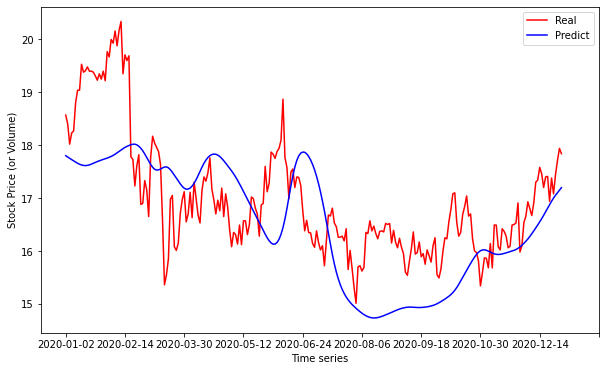

R2Walgreens Boots Alliance (USA)=0.5231420601418246


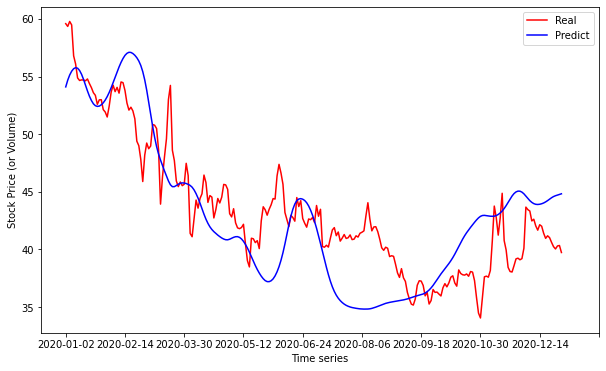

R2Metro (Canada)=0.8478716990983044


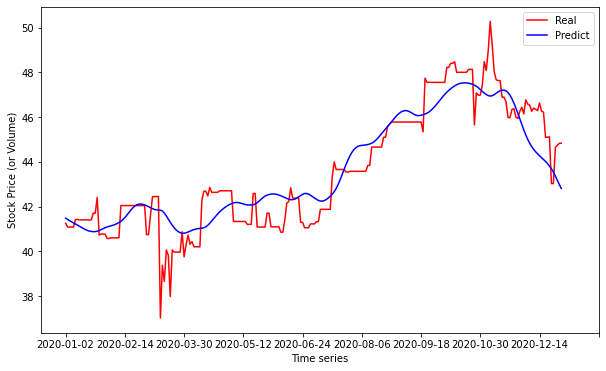

R2Coop Group (Switzerland)'=0.13276296939744925


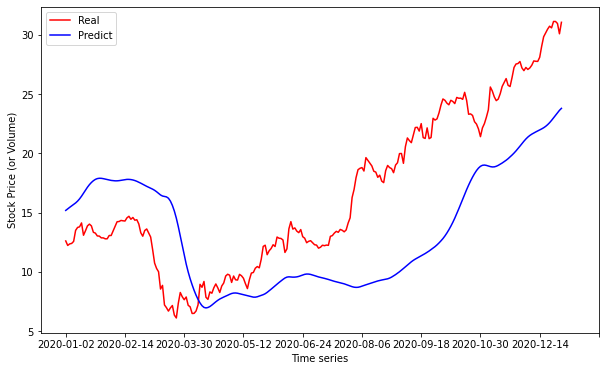

R2J.Sainsbury(Britain)=0.41212526815578865


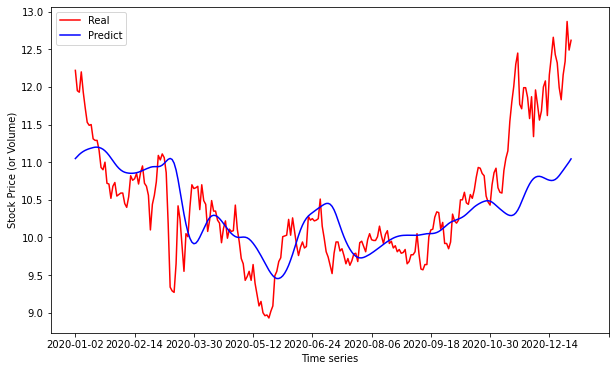

R2Royal Ahold Delhaize(Netherlands)=0.6119867521759217


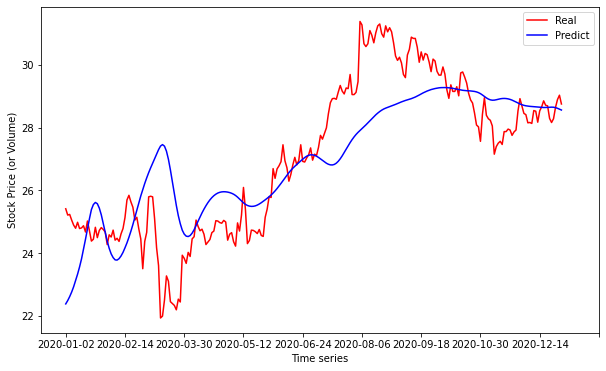

R2-6companies_average=0.43345946899909055

Preds_Heatmap=High correlation


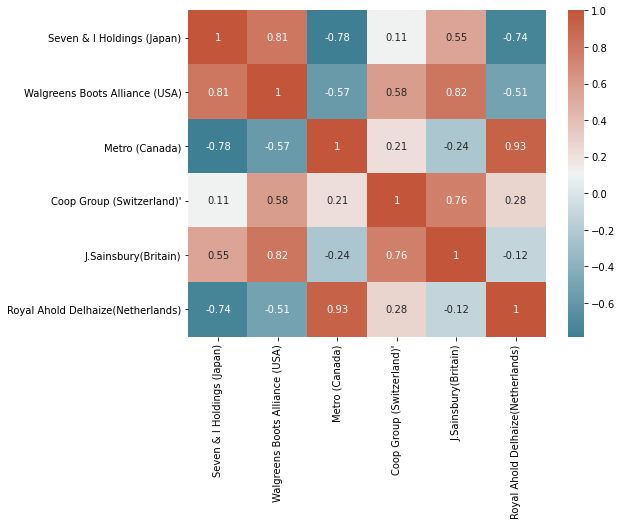

In [ ]:
# test(prediction)
t2 = make_preds(data, company_list, input, o3, o4, V=V, output_c=output_c, output_i=output_i, train_size=train_size, time_step=time_step)

#N=7

In [ ]:
data=[df1, df2, df3, df4, df5, df6, df7] 
company_list=["Seven & I Holdings (Japan)", "Walgreens Boots Alliance (USA)", "Metro (Canada)", "Coop Group (Switzerland)", "J.Sainsbury(Britain)",
    "Royal Ahold Delhaize(Netherlands)", "Tesco(Britain)"]
items={"Date":0, "Open":1, "High":2, "Low":3, "Close":4, "Adj Close":5, "Volume":6}

# Basically, we can remove "Date" and "Adj Close"
input=[2] #item' index chosen as imputs
output_c=['High'] # item values of output
output_i=[2] # item number of output

train_size=754
time_step=60
epochs=20
units=120 # number of nodes

# V means whether "Volume" may be included or not
if 6 not in input:
  V=False
else: V=True

In [ ]:
# train 
o3, o4 = make_models(data, company_list, input, V=V, output_c=output_c, output_i=output_i, 
                     train_size=train_size, time_step=time_step, epochs=epochs, units=units)

train_data=(7, 754, 1), test_data=(7, 252, 1)
volule以外かつinputとoutputは1つ
num_of_companies=7, ind=[0, 1, 2, 3, 4, 5, 6]
X_train=(694, 60, 7), y_trains=(4858,)
y_trains2=(7, 694)
Check
1/7
Epoch 1/20
22/22 [==============================] - 29s 257ms/step - loss: 0.4204
Epoch 2/20
22/22 [==============================] - 6s 252ms/step - loss: 0.1123
Epoch 3/20
22/22 [==============================] - 6s 253ms/step - loss: 0.0755
Epoch 4/20
22/22 [==============================] - 6s 252ms/step - loss: 0.0739
Epoch 5/20
22/22 [==============================] - 6s 252ms/step - loss: 0.0618
Epoch 6/20
22/22 [==============================] - 6s 251ms/step - loss: 0.0542
Epoch 7/20
22/22 [==============================] - 6s 252ms/step - loss: 0.0595
Epoch 8/20
22/22 [==============================] - 6s 251ms/step - loss: 0.0658
Epoch 9/20
22/22 [==============================] - 6s 252ms/step - loss: 0.0584
Epoch 10/20
22/22 [==============================] - 6s 251ms/step - loss: 0.0544
Ep

train_data=(7, 754, 1), test_data=(7, 252, 1)
inputs = (7, 312, 1)
inputs2=(312, 7)
X_test=(252, 60, 7)
finish making predictions
actual lists=(7, 252), preds_list=(7, 252, 1)
[6]
R2Seven & I Holdings (Japan)=-0.4193323530238793


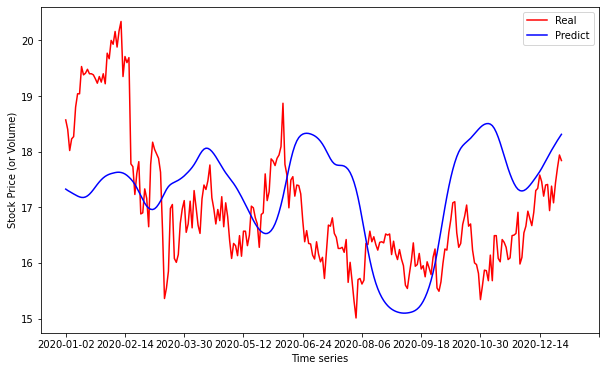

R2Walgreens Boots Alliance (USA)=0.20822170667026663


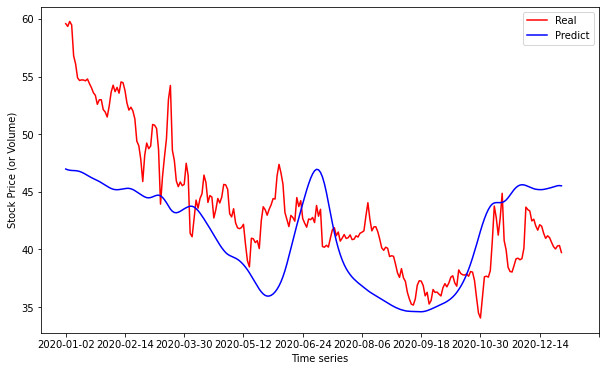

R2Metro (Canada)=0.736543345414149


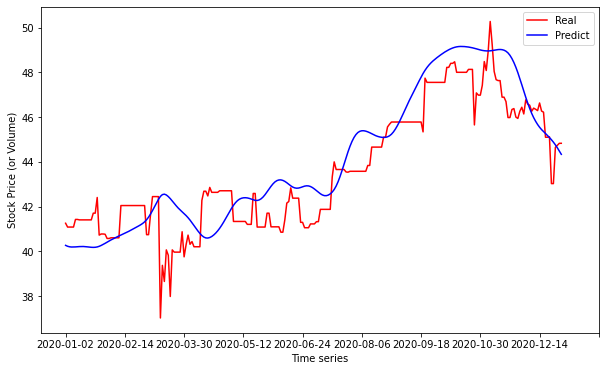

R2Coop Group (Switzerland)=-0.09957661408483975


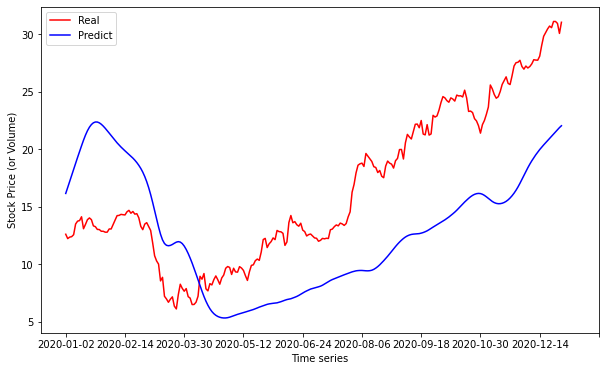

R2J.Sainsbury(Britain)=0.36227428847122467


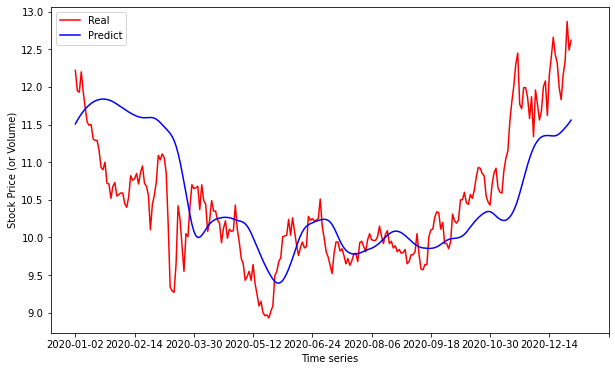

R2Royal Ahold Delhaize(Netherlands)=0.6587050893572635


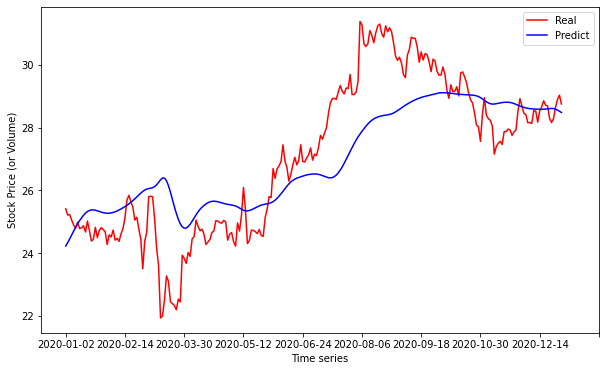

R2Tesco(Britain)=-0.18178343814942477


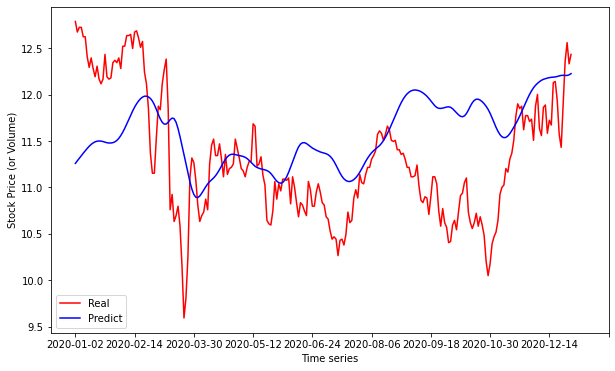

R2-7companies_average=0.18072171780782287

Preds_Heatmap=High correlation


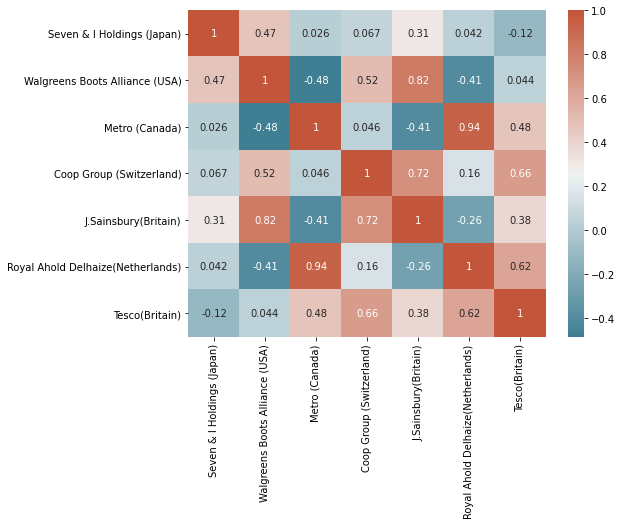

In [ ]:
# test(prediction)
t2 = make_preds(data, company_list, input, o3, o4, V=V, output_c=output_c, output_i=output_i, train_size=train_size, time_step=time_step)

#N=8

In [ ]:
data=[df1, df2, df3, df4, df5, df6, df7, df8] 
company_list=["Seven & I Holdings (Japan)", "Walgreens Boots Alliance (USA)", "Metro (Canada)", "Coop Group (Switzerland)", "J.Sainsbury(Britain)",
    "Royal Ahold Delhaize(Netherlands)", "Tesco(Britain)", "Kroger(USA)"]
items={"Date":0, "Open":1, "High":2, "Low":3, "Close":4, "Adj Close":5, "Volume":6}

# Basically, we can remove "Date" and "Adj Close"
input=[2] #item' index chosen as imputs
output_c=['High'] # item values of output
output_i=[2] # item number of output

train_size=754
time_step=60
epochs=20
units=120 # number of nodes

# V means whether "Volume" may be included or not
if 6 not in input:
  V=False
else: V=True

In [ ]:
# train 
o3, o4 = make_models(data, company_list, input, V=V, output_c=output_c, output_i=output_i, 
                     train_size=train_size, time_step=time_step, epochs=epochs, units=units)

train_data=(8, 754, 1), test_data=(8, 252, 1)
volule以外かつinputとoutputは1つ
num_of_companies=8, ind=[0, 1, 2, 3, 4, 5, 6, 7]
X_train=(694, 60, 8), y_trains=(5552,)
y_trains2=(8, 694)
Check
1/8
Epoch 1/20
22/22 [==============================] - 13s 259ms/step - loss: 0.4076
Epoch 2/20
22/22 [==============================] - 6s 254ms/step - loss: 0.0999
Epoch 3/20
22/22 [==============================] - 6s 255ms/step - loss: 0.0970
Epoch 4/20
22/22 [==============================] - 6s 255ms/step - loss: 0.0654
Epoch 5/20
22/22 [==============================] - 6s 255ms/step - loss: 0.0700
Epoch 6/20
22/22 [==============================] - 6s 254ms/step - loss: 0.0612
Epoch 7/20
22/22 [==============================] - 6s 256ms/step - loss: 0.0585
Epoch 8/20
22/22 [==============================] - 6s 255ms/step - loss: 0.0615
Epoch 9/20
22/22 [==============================] - 6s 255ms/step - loss: 0.0562
Epoch 10/20
22/22 [==============================] - 6s 255ms/step - loss: 0.0495

train_data=(8, 754, 1), test_data=(8, 252, 1)
inputs = (8, 312, 1)
inputs2=(312, 8)
X_test=(252, 60, 8)
finish making predictions
actual lists=(8, 252), preds_list=(8, 252, 1)
[7]
R2Seven & I Holdings (Japan)=-0.31194681107093913


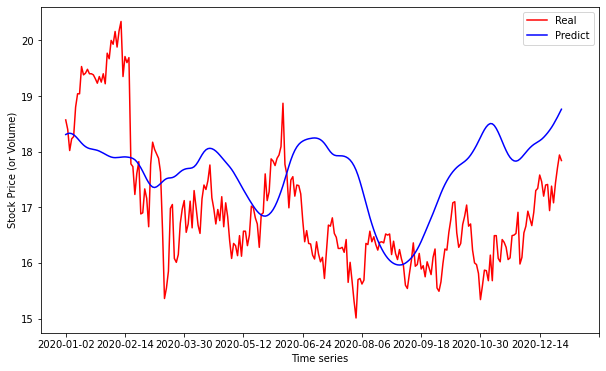

R2Walgreens Boots Alliance (USA)=-0.07545908433904414


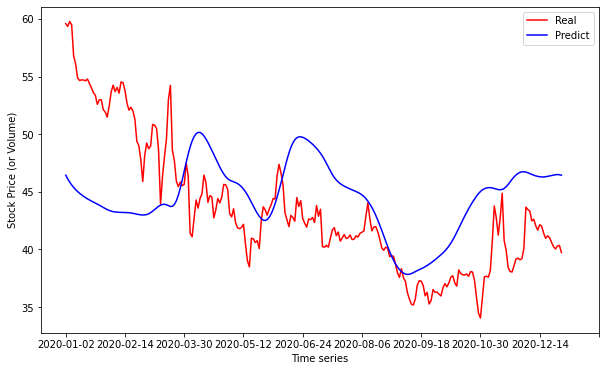

R2Metro (Canada)=0.8073997027540782


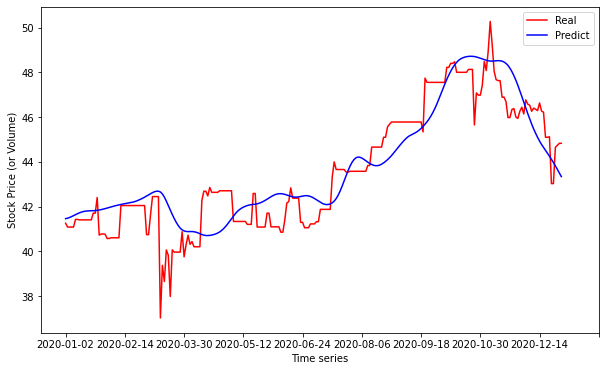

R2Coop Group (Switzerland)=0.4167912355493283


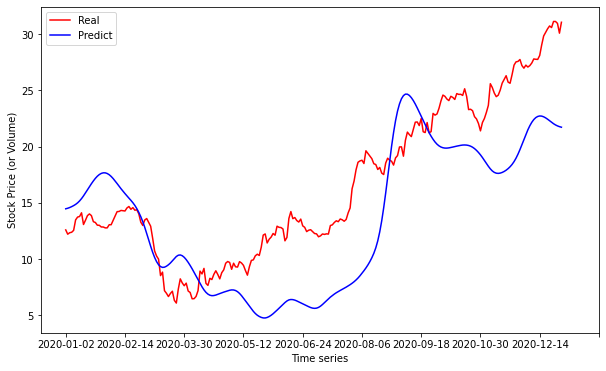

R2J.Sainsbury(Britain)=0.2721842349012714


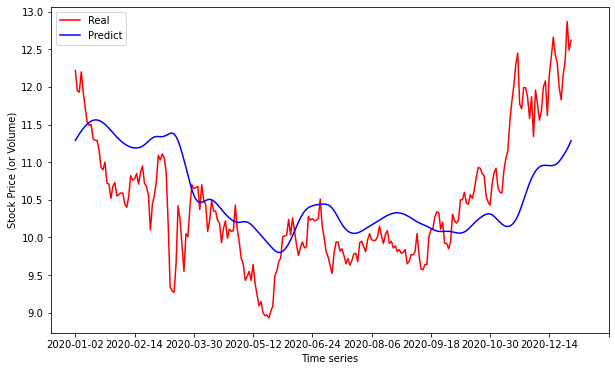

R2Royal Ahold Delhaize(Netherlands)=0.6740261571134627


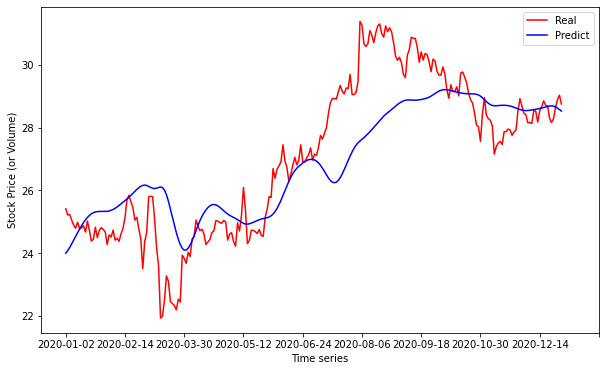

R2Tesco(Britain)=-0.43891420924548274


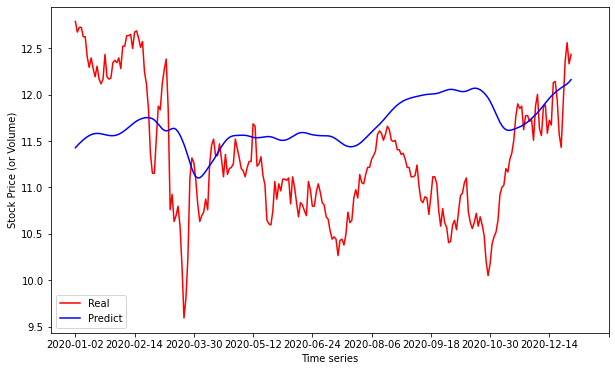

R2Kroger(USA)=0.06079250632828492


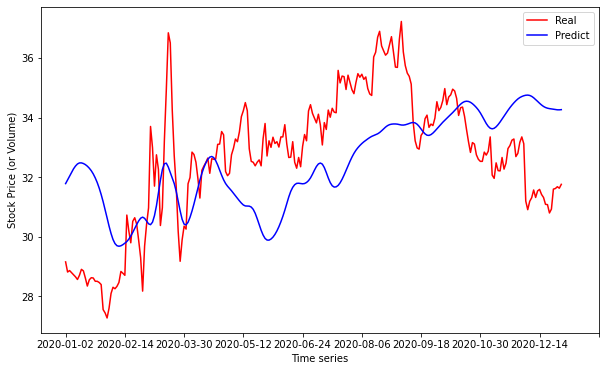

R2-8companies_average=0.17560921649886996

Preds_Heatmap=High correlation


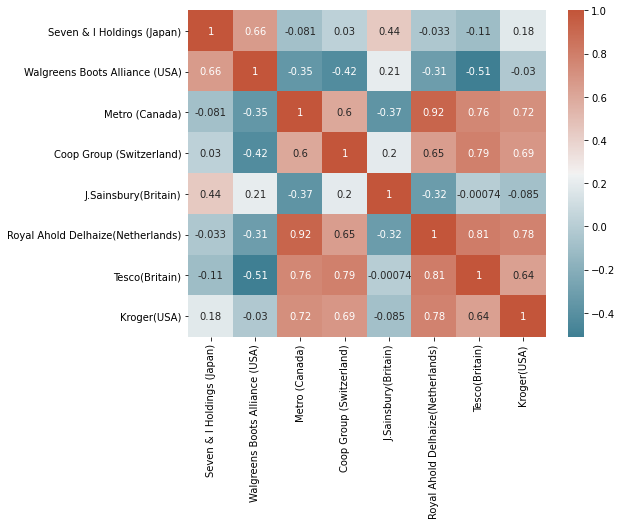

In [ ]:
# test(prediction)
t2 = make_preds(data, company_list, input, o3, o4, V=V, output_c=output_c, output_i=output_i, train_size=train_size, time_step=time_step)

# N=2 (epoch=50, nodes=150)

train_data=(2, 754, 1), test_data=(2, 252, 1)
volule以外かつinputとoutputは1つ
num_of_companies=2, ind=[0, 1]
X_train=(694, 60, 2), y_trains=(1388,)
y_trains2=(2, 694)
Check
1/2
Epoch 1/50
22/22 [==============================] - 15s 388ms/step - loss: 0.4790
Epoch 2/50
22/22 [==============================] - 8s 385ms/step - loss: 0.1521
Epoch 3/50
22/22 [==============================] - 9s 386ms/step - loss: 0.1271
Epoch 4/50
22/22 [==============================] - 9s 388ms/step - loss: 0.1035
Epoch 5/50
22/22 [==============================] - 8s 385ms/step - loss: 0.0947
Epoch 6/50
22/22 [==============================] - 9s 387ms/step - loss: 0.0946
Epoch 7/50
22/22 [==============================] - 8s 386ms/step - loss: 0.0805
Epoch 8/50
22/22 [==============================] - 9s 387ms/step - loss: 0.0762
Epoch 9/50
22/22 [==============================] - 8s 385ms/step - loss: 0.0716
Epoch 10/50
22/22 [==============================] - 9s 387ms/step - loss: 0.0699
Epoch 11/50
22/22

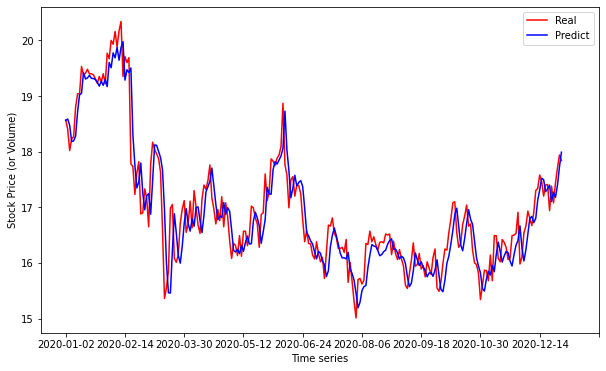

R2Walgreens Boots Alliance (USA)=0.9273559386762862


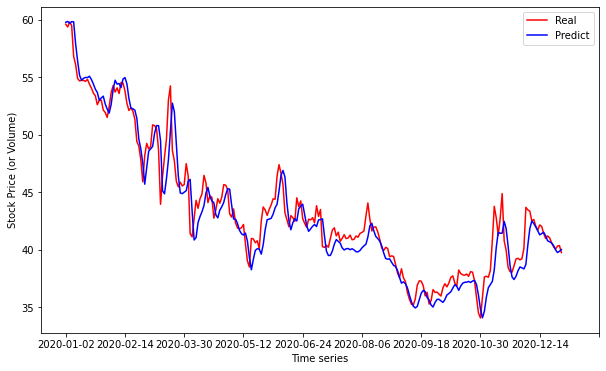

R2-2companies_average=0.9004222096033214

Preds_Heatmap=High correlation


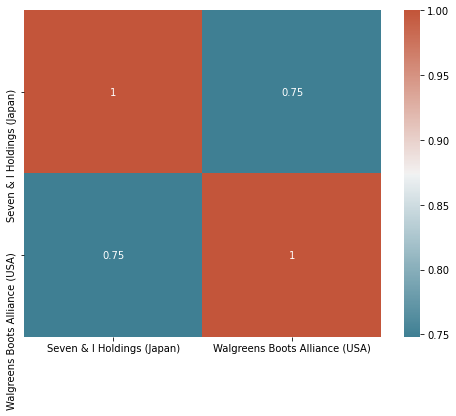

In [18]:
data=[df1, df2] 
company_list=["Seven & I Holdings (Japan)", "Walgreens Boots Alliance (USA)"]
items={"Date":0, "Open":1, "High":2, "Low":3, "Close":4, "Adj Close":5, "Volume":6}

# Basically, we can remove "Date" and "Adj Close"
input=[2] #item' index chosen as imputs
output_c=['High'] # item values of output
output_i=[2] # item number of output

train_size=754
time_step=60
epochs=50
units=150 # number of nodes

# V means whether "Volume" may be included or not
if 6 not in input:
  V=False
else: V=True

# train 
o3, o4 = make_models(data, company_list, input, V=V, output_c=output_c, output_i=output_i, 
                     train_size=train_size, time_step=time_step, epochs=epochs, units=units)

# test(prediction)
t2 = make_preds(data, company_list, input, o3, o4, V=V, output_c=output_c, output_i=output_i, train_size=train_size, time_step=time_step)

In [22]:
data=[df1, df2, df3] 
company_list=["Seven & I Holdings (Japan)", "Walgreens Boots Alliance (USA)", "Metro (Canada)"]
items={"Date":0, "Open":1, "High":2, "Low":3, "Close":4, "Adj Close":5, "Volume":6}

# Basically, we can remove "Date" and "Adj Close"
input=[2] #item' index chosen as imputs
output_c=['High'] # item values of output
output_i=[2] # item number of output

train_size=754
time_step=60
epochs=50
units=150 # number of nodes

# V means whether "Volume" may be included or not
if 6 not in input:
  V=False
else: V=True

# train 
o3, o4 = make_models(data, company_list, input, V=V, output_c=output_c, output_i=output_i, 
                     train_size=train_size, time_step=time_step, epochs=epochs, units=units)

# test(prediction)
t2 = make_preds(data, company_list, input, o3, o4, V=V, output_c=output_c, output_i=output_i, train_size=train_size, time_step=time_step)

train_data=(3, 754, 1), test_data=(3, 252, 1)
volule以外かつinputとoutputは1つ
num_of_companies=3, ind=[0, 1, 2]
X_train=(694, 60, 3), y_trains=(2082,)
y_trains2=(3, 694)
Check
1/3
Epoch 1/50


KeyboardInterrupt: ignored

In [ ]:
data=[df1, df2] 
company_list=["Seven & I Holdings (Japan)", "Walgreens Boots Alliance (USA)"]
items={"Date":0, "Open":1, "High":2, "Low":3, "Close":4, "Adj Close":5, "Volume":6}

# Basically, we can remove "Date" and "Adj Close"
input=[2] #item' index chosen as imputs
output_c=['High'] # item values of output
output_i=[2] # item number of output

train_size=754
time_step=60
epochs=50
units=150 # number of nodes

# V means whether "Volume" may be included or not
if 6 not in input:
  V=False
else: V=True

# train 
o3, o4 = make_models(data, company_list, input, V=V, output_c=output_c, output_i=output_i, 
                     train_size=train_size, time_step=time_step, epochs=epochs, units=units)

# test(prediction)
t2 = make_preds(data, company_list, input, o3, o4, V=V, output_c=output_c, output_i=output_i, train_size=train_size, time_step=time_step)

In [ ]:
data=[df1, df2] 
company_list=["Seven & I Holdings (Japan)", "Walgreens Boots Alliance (USA)"]
items={"Date":0, "Open":1, "High":2, "Low":3, "Close":4, "Adj Close":5, "Volume":6}

# Basically, we can remove "Date" and "Adj Close"
input=[2] #item' index chosen as imputs
output_c=['High'] # item values of output
output_i=[2] # item number of output

train_size=754
time_step=60
epochs=50
units=150 # number of nodes

# V means whether "Volume" may be included or not
if 6 not in input:
  V=False
else: V=True

# train 
o3, o4 = make_models(data, company_list, input, V=V, output_c=output_c, output_i=output_i, 
                     train_size=train_size, time_step=time_step, epochs=epochs, units=units)

# test(prediction)
t2 = make_preds(data, company_list, input, o3, o4, V=V, output_c=output_c, output_i=output_i, train_size=train_size, time_step=time_step)

In [ ]:
data=[df1, df2] 
company_list=["Seven & I Holdings (Japan)", "Walgreens Boots Alliance (USA)"]
items={"Date":0, "Open":1, "High":2, "Low":3, "Close":4, "Adj Close":5, "Volume":6}

# Basically, we can remove "Date" and "Adj Close"
input=[2] #item' index chosen as imputs
output_c=['High'] # item values of output
output_i=[2] # item number of output

train_size=754
time_step=60
epochs=50
units=150 # number of nodes

# V means whether "Volume" may be included or not
if 6 not in input:
  V=False
else: V=True

# train 
o3, o4 = make_models(data, company_list, input, V=V, output_c=output_c, output_i=output_i, 
                     train_size=train_size, time_step=time_step, epochs=epochs, units=units)

# test(prediction)
t2 = make_preds(data, company_list, input, o3, o4, V=V, output_c=output_c, output_i=output_i, train_size=train_size, time_step=time_step)

# N=2~4(Volume)

train_data=(2, 754, 1), test_data=(2, 252, 1)
Here check
output=1, inputs=[6], outputs=['Volume']
concat=(754, 2)
num_of_companies=2, ind=[0, 1]
X_train=(694, 60, 2), y_trains=(1388,)
y_trains2=(2, 694)
Check
1/2
Epoch 1/20
22/22 [==============================] - 28s 252ms/step - loss: 0.6767
Epoch 2/20
22/22 [==============================] - 6s 250ms/step - loss: 0.8843
Epoch 3/20
22/22 [==============================] - 5s 249ms/step - loss: 0.4862
Epoch 4/20
22/22 [==============================] - 5s 246ms/step - loss: 0.5805
Epoch 5/20
22/22 [==============================] - 6s 252ms/step - loss: 0.5904
Epoch 6/20
22/22 [==============================] - 5s 249ms/step - loss: 0.5861
Epoch 7/20
22/22 [==============================] - 5s 250ms/step - loss: 0.5480
Epoch 8/20
22/22 [==============================] - 6s 251ms/step - loss: 0.6896
Epoch 9/20
22/22 [==============================] - 5s 247ms/step - loss: 0.5252
Epoch 10/20
22/22 [==============================] - 5s 2

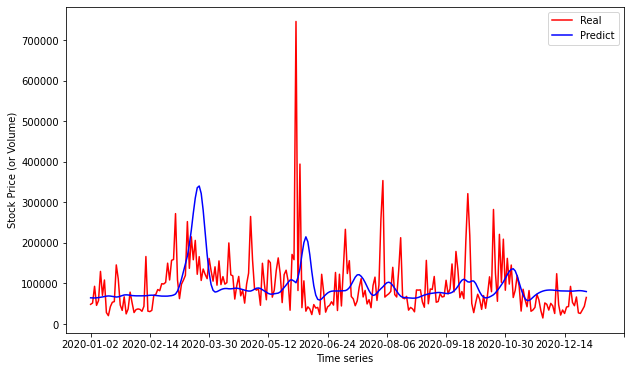

R2Walgreens Boots Alliance (USA)=0.14210151984028052


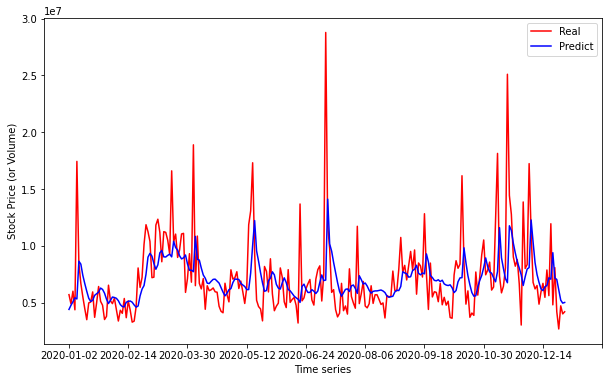

R2-2companies_average=0.01132407932717211

Preds_Heatmap=Volume correlation


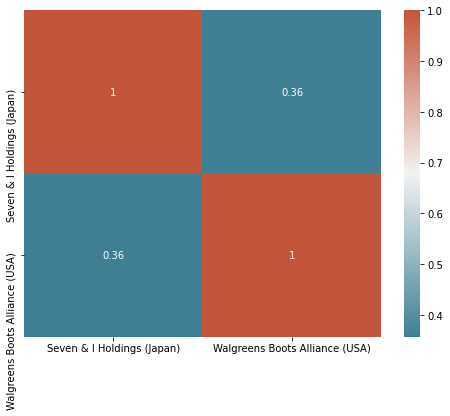

In [6]:
data=[df1, df2] 
company_list=["Seven & I Holdings (Japan)", "Walgreens Boots Alliance (USA)"]
items={"Date":0, "Open":1, "High":2, "Low":3, "Close":4, "Adj Close":5, "Volume":6}

# Basically, we can remove "Date" and "Adj Close"
input=[6] #item' index chosen as imputs
output_c=['Volume'] # item values of output
output_i=[6] # item number of output

train_size=754
time_step=60
epochs=20
units=120 # number of nodes

# V means whether "Volume" may be included or not
if 6 not in input:
  V=False
else: V=True

# train 
o3, o4 = make_models(data, company_list, input, V=V, output_c=output_c, output_i=output_i, 
                     train_size=train_size, time_step=time_step, epochs=epochs, units=units)

# test(prediction)
t2 = make_preds(data, company_list, input, o3, o4, V=V, output_c=output_c, output_i=output_i, train_size=train_size, time_step=time_step)

train_data=(3, 754, 1), test_data=(3, 252, 1)
Here check
output=1, inputs=[6], outputs=['Volume']
concat=(754, 3)
num_of_companies=3, ind=[0, 1, 2]
X_train=(694, 60, 3), y_trains=(2082,)
y_trains2=(3, 694)
Check
1/3
Epoch 1/20
22/22 [==============================] - 12s 252ms/step - loss: 0.7485
Epoch 2/20
22/22 [==============================] - 6s 251ms/step - loss: 2.3878
Epoch 3/20
22/22 [==============================] - 6s 254ms/step - loss: 0.6660
Epoch 4/20
22/22 [==============================] - 6s 252ms/step - loss: 0.4355
Epoch 5/20
22/22 [==============================] - 5s 250ms/step - loss: 1.0857
Epoch 6/20
22/22 [==============================] - 6s 250ms/step - loss: 0.3911
Epoch 7/20
22/22 [==============================] - 5s 249ms/step - loss: 0.4503
Epoch 8/20
22/22 [==============================] - 6s 251ms/step - loss: 1.3442
Epoch 9/20
22/22 [==============================] - 5s 248ms/step - loss: 0.4610
Epoch 10/20
22/22 [==============================] - 6

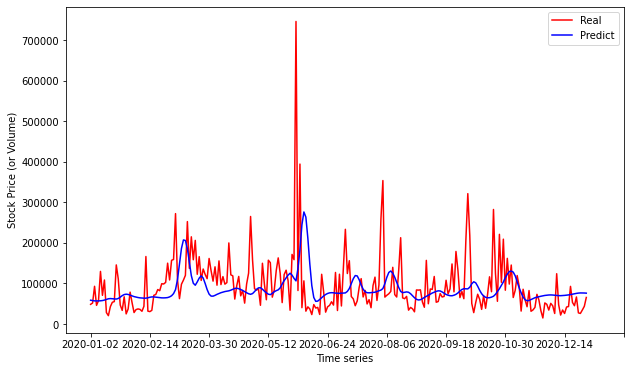

R2Walgreens Boots Alliance (USA)=0.09209557165888449


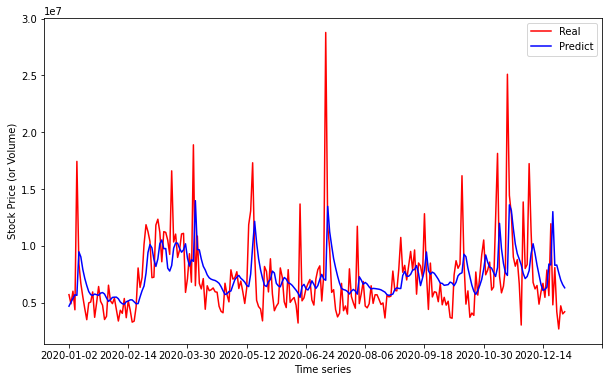

R2Metro (Canada)=-0.0011955794222162641


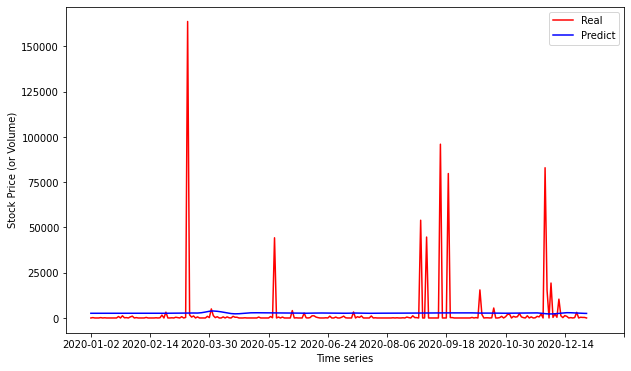

R2-3companies_average=0.009423798240265327

Preds_Heatmap=Volume correlation


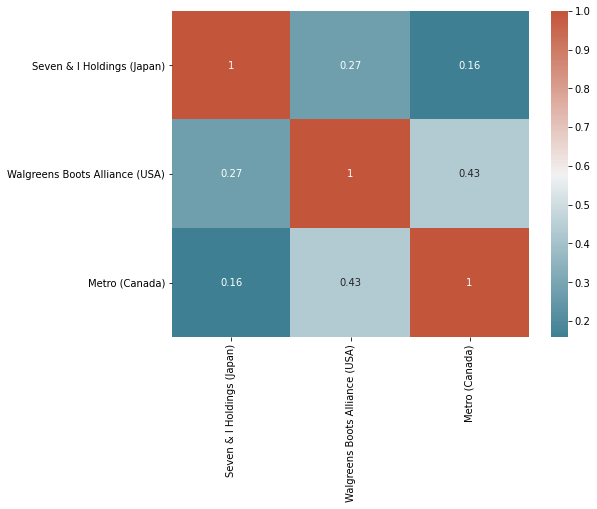

In [7]:
data=[df1, df2, df3] 
company_list=["Seven & I Holdings (Japan)", "Walgreens Boots Alliance (USA)", "Metro (Canada)"]
items={"Date":0, "Open":1, "High":2, "Low":3, "Close":4, "Adj Close":5, "Volume":6}

# Basically, we can remove "Date" and "Adj Close"
input=[6] #item' index chosen as imputs
output_c=['Volume'] # item values of output
output_i=[6] # item number of output

train_size=754
time_step=60
epochs=20
units=120 # number of nodes

# V means whether "Volume" may be included or not
if 6 not in input:
  V=False
else: V=True

# train 
o3, o4 = make_models(data, company_list, input, V=V, output_c=output_c, output_i=output_i, 
                     train_size=train_size, time_step=time_step, epochs=epochs, units=units)

# test(prediction)
t2 = make_preds(data, company_list, input, o3, o4, V=V, output_c=output_c, output_i=output_i, train_size=train_size, time_step=time_step)

train_data=(4, 754, 1), test_data=(4, 252, 1)
Here check
output=1, inputs=[6], outputs=['Volume']
concat=(754, 4)
num_of_companies=4, ind=[0, 1, 2, 3]
X_train=(694, 60, 4), y_trains=(2776,)
y_trains2=(4, 694)
Check
1/4
Epoch 1/20
22/22 [==============================] - 12s 254ms/step - loss: 1.0979
Epoch 2/20
22/22 [==============================] - 6s 254ms/step - loss: 0.6784
Epoch 3/20
22/22 [==============================] - 5s 249ms/step - loss: 1.4025
Epoch 4/20
22/22 [==============================] - 6s 253ms/step - loss: 0.4984
Epoch 5/20
22/22 [==============================] - 6s 251ms/step - loss: 0.9580
Epoch 6/20
22/22 [==============================] - 6s 252ms/step - loss: 0.6224
Epoch 7/20
22/22 [==============================] - 6s 251ms/step - loss: 1.1328
Epoch 8/20
22/22 [==============================] - 5s 249ms/step - loss: 0.2058
Epoch 9/20
22/22 [==============================] - 6s 253ms/step - loss: 0.3119
Epoch 10/20
22/22 [==============================] 

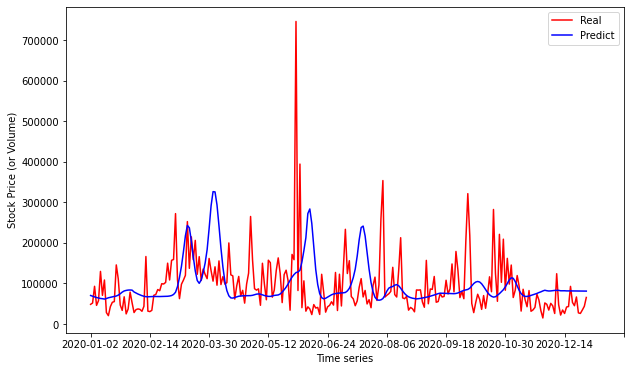

R2Walgreens Boots Alliance (USA)=-0.08160104611939412


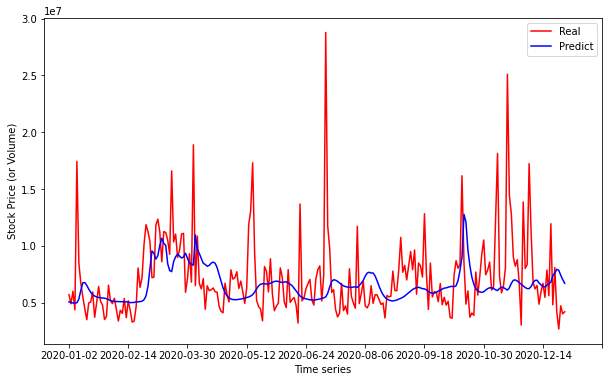

R2Metro (Canada)=-0.07721951943521854


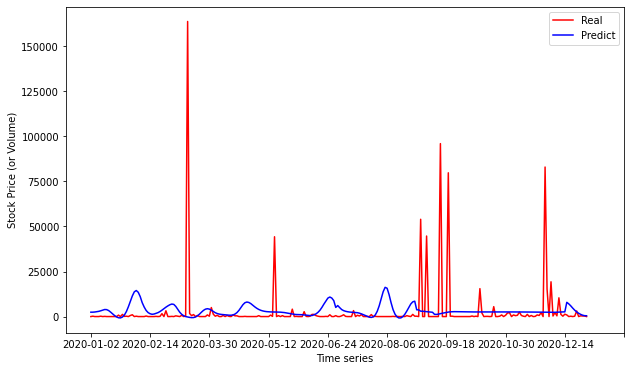

R2Coop Group (Switzerland)=-0.037200191826690876


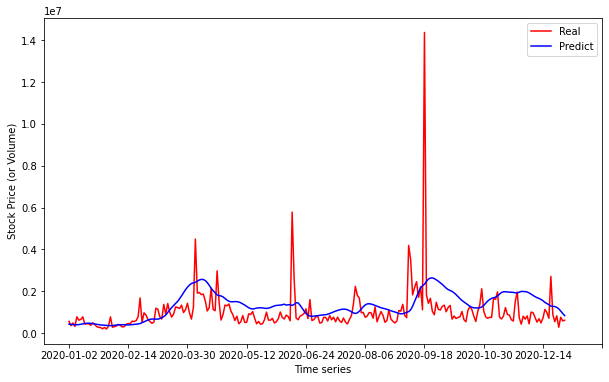

R2-4companies_average=-0.13394305111481902

Preds_Heatmap=Volume correlation


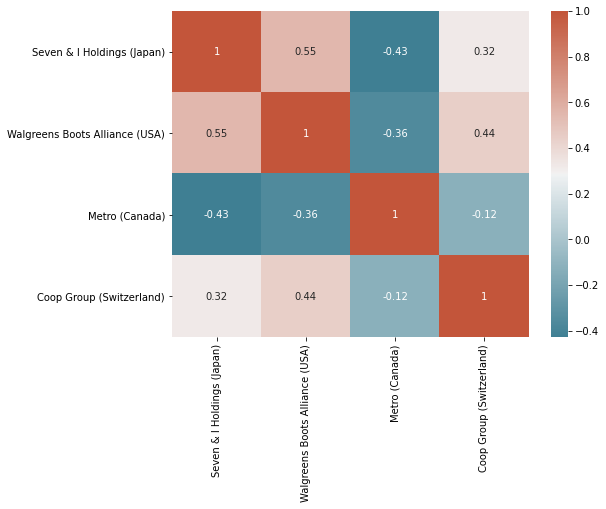

In [8]:
data=[df1, df2, df3, df4] 
company_list=["Seven & I Holdings (Japan)", "Walgreens Boots Alliance (USA)", "Metro (Canada)", "Coop Group (Switzerland)"]
items={"Date":0, "Open":1, "High":2, "Low":3, "Close":4, "Adj Close":5, "Volume":6}

# Basically, we can remove "Date" and "Adj Close"
input=[6] #item' index chosen as imputs
output_c=['Volume'] # item values of output
output_i=[6] # item number of output

train_size=754
time_step=60
epochs=20
units=120 # number of nodes

# V means whether "Volume" may be included or not
if 6 not in input:
  V=False
else: V=True

# train 
o3, o4 = make_models(data, company_list, input, V=V, output_c=output_c, output_i=output_i, 
                     train_size=train_size, time_step=time_step, epochs=epochs, units=units)

# test(prediction)
t2 = make_preds(data, company_list, input, o3, o4, V=V, output_c=output_c, output_i=output_i, train_size=train_size, time_step=time_step)

# Change window size (3years : 1year => 3.5years : 0.5years)

train_data=(2, 880, 1), test_data=(2, 126, 1)
volule以外かつinputとoutputは1つ
num_of_companies=2, ind=[0, 1]
X_train=(820, 60, 2), y_trains=(1640,)
y_trains2=(2, 820)
Check
1/2
Epoch 1/40
26/26 [==============================] - 15s 253ms/step - loss: 0.5077
Epoch 2/40
26/26 [==============================] - 7s 254ms/step - loss: 0.1406
Epoch 3/40
26/26 [==============================] - 6s 249ms/step - loss: 0.1268
Epoch 4/40
26/26 [==============================] - 7s 251ms/step - loss: 0.0985
Epoch 5/40
26/26 [==============================] - 7s 251ms/step - loss: 0.1014
Epoch 6/40
26/26 [==============================] - 7s 254ms/step - loss: 0.1029
Epoch 7/40
26/26 [==============================] - 7s 254ms/step - loss: 0.0954
Epoch 8/40
26/26 [==============================] - 6s 249ms/step - loss: 0.0850
Epoch 9/40
26/26 [==============================] - 6s 250ms/step - loss: 0.0834
Epoch 10/40
26/26 [==============================] - 7s 250ms/step - loss: 0.0674
Epoch 11/40
26/26

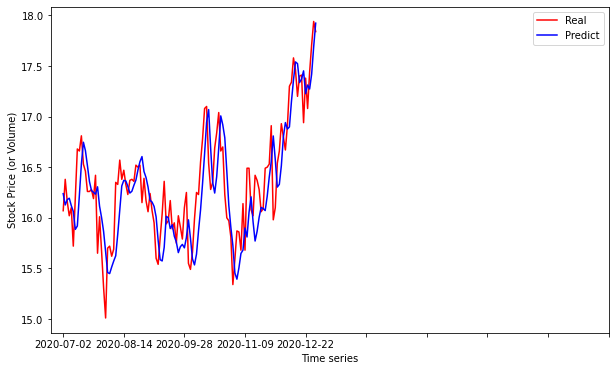

R2Walgreens Boots Alliance (USA)=0.7445143389448226


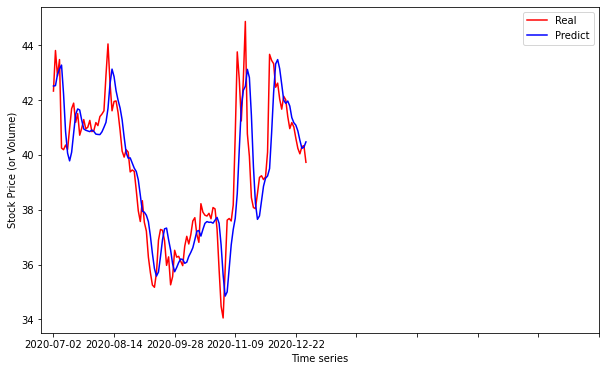

R2-2companies_average=0.6898337540494001

Preds_Heatmap=High correlation


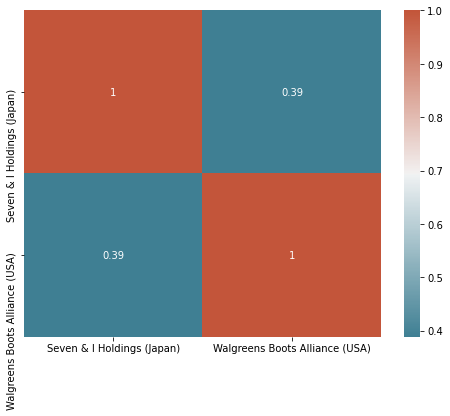

In [21]:
data=[df1, df2] 
company_list=["Seven & I Holdings (Japan)", "Walgreens Boots Alliance (USA)"]
items={"Date":0, "Open":1, "High":2, "Low":3, "Close":4, "Adj Close":5, "Volume":6}

# Basically, we can remove "Date" and "Adj Close"
input=[2] #item' index chosen as imputs
output_c=['High'] # item values of output
output_i=[2] # item number of output

train_size=754+126
time_step=60
epochs=40
units=120 # number of nodes

# V means whether "Volume" may be included or not
if 6 not in input: V=False
else: V=True

# train 
o3, o4 = make_models(data, company_list, input, V=V, output_c=output_c, output_i=output_i, 
                     train_size=train_size, time_step=time_step, epochs=epochs, units=units)

# test(prediction)
t2 = make_preds(data, company_list, input, o3, o4, V=V, output_c=output_c, output_i=output_i, train_size=train_size, time_step=time_step)